In [ ]:
import torch
import torch.nn as nn
import firedrake as fd
import firedrake_adjoint  # noqa
import numpy as np
import ufl
from torchfire import fd_to_torch
import fdm
from fecr import evaluate_primal, evaluate_pullback
from torch.autograd import Variable
import torchviz
import matplotlib.pyplot as plt

#def neural_net(n_input, n_hidden, n_output):
#    model = nn.Sequential(nn.Flatten(),
#                          nn.Linear(n_input, n_hidden),
#                          nn.LeakyReLU(),
#                          nn.Linear(n_hidden, n_output),
#                          nn.ReLU())
#    return model

class neural_net(torch.nn.Module):

    def __init__(self):
        super(neural_net, self).__init__()
        self.linear1 = nn.Linear(27, 32)
        self.activation1 = nn.ReLU()
        self.linear2 = torch.nn.Linear(32, 32)
        self.activation2 = nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 32)
        self.activation3 = nn.ReLU()
        self.linear4 = torch.nn.Linear(32, 27)
        self.activation4 = nn.Tanh()

    def forward(self, x):
        x = torch.flatten(x)
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x

def a_function(f):
    V = fd.FunctionSpace(mesh, "P", 1)
    x = fd.SpatialCoordinate(mesh)

    u = fd.Function(V)
    v = fd.TestFunction(V)
    bcs = [fd.DirichletBC(V, fd.Constant(2.0), (1,))]

    a = (fd.inner(fd.grad(u), fd.grad(v))  - f * v  )* fd.dx

    fd.solve( a  == 0, u, bcs=bcs)
    return u

def F_function(f):
    x = fd.SpatialCoordinate(mesh)
    F = fd.Function(V)
    F.interpolate(fd.sin(x[0] * fd.pi) * fd.sin(2 * x[1] * fd.pi))
    return F





In [ ]:
N = 8
mesh = fd.UnitSquareMesh(N, 2)
V = fd.FunctionSpace(mesh, "P", 1)
V_f = fd.FunctionSpace(mesh, "P", 1)
x = fd.SpatialCoordinate(mesh)
print(V.dim())
print(V_f.dim())

In [ ]:
fd.Function(V)

In [ ]:
F_templates = (fd.Function(V), )
F_input = (torch.ones(V.dim(), requires_grad=False),)
F = fd_to_torch(F_function, F_templates, "bob_F")
F_ = F.apply(*F_input)
F_

In [ ]:
templates = (fd.Function(V_f),)
inputs = (torch.ones(V_f.dim(), requires_grad=True),)
a = fd_to_torch(a_function, templates, "bob_a")
a_ = a.apply

In [ ]:
error_L2 = nn.MSELoss()
learning_rate = 0.0001
f_nn = neural_net() #neural_net(N, 68, N)
optimizer = torch.optim.Adam(f_nn.parameters(), lr=learning_rate)
losses = []

for epoch in range(100):
    print(f"Epoch:{epoch}")
    f = f_nn(*inputs)
    y = a_(f)

    loss = error_L2(y, F_)
    grad_x, = torch.autograd.grad(loss, inputs, create_graph=True)
    torchviz.make_dot((grad_x, inputs[0] , loss), params={"grad_x": grad_x, "x": inputs[0], "out": loss}).render("attached",format="png")
    losses.append(loss)
    print(f"Loss:{loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot([loss.detach() for loss in losses][1:])
#plt.savefig('losses.png')
plt.show()
plt.close()
print("Predicted f:", f.detach().numpy())
print("True f:", F_)
plt.plot(f.detach().numpy())
plt.show()
#plt.savefig('f.png')

Epoch:0
Loss:4.0219575610035445
Epoch:1
Loss:4.021032442841373
Epoch:2
Loss:4.020111505550467
Epoch:3
Loss:4.019187613755018
Epoch:4
Loss:4.018260719156394
Epoch:5
Loss:4.017229860615812
Epoch:6
Loss:4.016147963129546
Epoch:7
Loss:4.015051739390418
Epoch:8
Loss:4.013944274271538
Epoch:9
Loss:4.012870474827048
Epoch:10
Loss:4.011812987508217
Epoch:11
Loss:4.010749578666955
Epoch:12
Loss:4.009680586474194
Epoch:13
Loss:4.008606227472103
Epoch:14
Loss:4.007526622423931
Epoch:15
Loss:4.006441823878701
Epoch:16
Loss:4.0053518068539065
Epoch:17
Loss:4.004248292339359
Epoch:18
Loss:4.003124272463939
Epoch:19
Loss:4.001990923527889
Epoch:20
Loss:4.000901499211526
Epoch:21
Loss:3.999817899218673
Epoch:22
Loss:3.9987232688575265
Epoch:23
Loss:3.997618042022069
Epoch:24
Loss:3.99650243930246
Epoch:25
Loss:3.995376528289619
Epoch:26
Loss:3.994240124940893
Epoch:27
Loss:3.9930922682589367
Epoch:28
Loss:3.991933433683514
Epoch:29
Loss:3.990762968231732
Epoch:30
Loss:3.989580257320662
Epoch:31
Loss:3

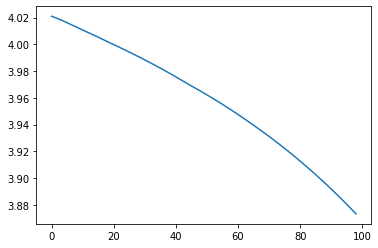

Predicted f: [ 0.08786244 -0.38091692  0.12359391 -0.12595344 -0.20994073  0.23599055
 -0.29863063 -0.0019078  -0.15475343 -0.22735175 -0.12747812  0.18402287
 -0.00444371 -0.24089554  0.11788008 -0.22093609 -0.1677989  -0.33228728
 -0.03222354 -0.3101312  -0.07771757 -0.07459402 -0.08517626 -0.13846721
 -0.01916483  0.07283058  0.2961348 ]
True f: tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.6865e-17,  0.0000e+00,
        -0.0000e+00,  8.6596e-17, -9.3730e-17,  0.0000e+00,  1.1314e-16,
        -1.7319e-16,  0.0000e+00,  1.2246e-16, -2.2629e-16,  0.0000e+00,
         1.1314e-16, -2.4493e-16,  0.0000e+00,  8.6596e-17, -2.2629e-16,
         0.0000e+00,  4.6865e-17, -1.7319e-16,  0.0000e+00,  1.4998e-32,
        -9.3730e-17, -2.9995e-32], dtype=torch.float64)


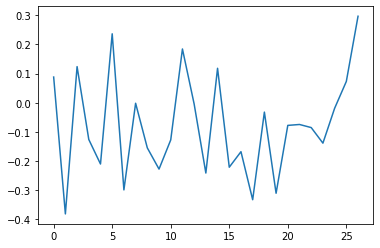

In [10]:
error_L2 = nn.MSELoss()
learning_rate = 0.0001
f_nn = neural_net() #neural_net(N, 68, N)
optimizer = torch.optim.Adam(f_nn.parameters(), lr=learning_rate)
losses = []

for epoch in range(100):
    print(f"Epoch:{epoch}")
    f = f_nn(*inputs)
    y = a_(f)

    loss = error_L2(y, F_)
    grad_x, = torch.autograd.grad(loss, inputs, create_graph=True)
    torchviz.make_dot((grad_x, inputs[0] , loss), params={"grad_x": grad_x, "x": inputs[0], "out": loss}).render("attached",format="png")
    losses.append(loss)
    print(f"Loss:{loss}")

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot([loss.detach() for loss in losses][1:])
#plt.savefig('losses.png')
plt.show()
plt.close()
print("Predicted f:", f.detach().numpy())
print("True f:", F_)
plt.plot(f.detach().numpy())
plt.show()
#plt.savefig('f.png')